# Extraction and plot of CPU power consumption from DGEMM archives

In [ ]:
archive_names = [
    'nancy_2021-02-26_2909483.zip',
    'nancy_2021-03-02_2911647.zip',
    'nancy_2021-03-03_2913178.zip'
]

In [2]:
import io
import zipfile
import requests
import pandas
import re
import os
import numpy
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import cashew
print(cashew.__version__)
print(cashew.__git_version__)
from cashew import archive_extraction as ae

def download_file(archive_name, base_url='https://gitlab.in2p3.fr/cornebize/g5k_test/-/raw/master/data/', directory='/tmp'):
    data = requests.get(base_url + archive_name)
    if data.status_code != 200:
        raise ValueError(f'Could not download the file, got an error {data.status_code}')
    path = os.path.join(directory, archive_name)
    with open(path, 'wb') as f:
        f.write(data.content)
    return path

0.2.5
4c081a41e9384b3ed9b7ed9775c835328e28f5eb


In [3]:
archives = [download_file(name) for name in archive_names]
archives

['/tmp/nancy_2021-02-26_2909483.zip',
 '/tmp/nancy_2021-03-02_2911647.zip',
 '/tmp/nancy_2021-03-03_2913178.zip']

In [4]:
import re
import numpy

dataframes = []
for f in archives:
    tmp = ae. read_monitoring(f)
    tmp['expfile'] = ae.read_yaml(f, 'info.yaml')['expfile'][0]
    dataframes.append(tmp)

df = pandas.concat(dataframes)
df.head()

,timestamp,cluster,node,jobid,start_time,expfile_hash,value,cpu,core,kind,start_exp,stop_exp,expfile
0,1.614331e+09,gros,1,2909483,1614326874,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,2.904016,0,0,frequency,1.614332e+09,1.614333e+09,exp.csv
1,1.614331e+09,gros,1,2909483,1614326874,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,1.425354,0,0,frequency,1.614332e+09,1.614333e+09,exp.csv
2,1.614331e+09,gros,1,2909483,1614326874,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,2.699914,0,0,frequency,1.614332e+09,1.614333e+09,exp.csv
3,1.614331e+09,gros,1,2909483,1614326874,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,2.699914,0,0,frequency,1.614332e+09,1.614333e+09,exp.csv
4,1.614331e+09,gros,1,2909483,1614326874,62ddffeaedbe72316dcde2062c531e9d8440340e568b29...,2.699914,0,0,frequency,1.614332e+09,1.614333e+09,exp.csv


In [5]:
def plot_evolution(df, y_val):
    df = df.copy()
    for jobid in df['jobid'].unique():
        df.loc[df['jobid'] == jobid, 'start_job'] = df[df['jobid'] == jobid]['timestamp'].min()
    df['timestamp'] -= df['start_job']
    start = df[['jobid', 'start_exp', 'start_job']].drop_duplicates()
    stop = df[['jobid', 'stop_exp', 'start_job']].drop_duplicates()
    start['x'] = start['start_exp'] - start['start_job']
    stop['x'] = stop['stop_exp'] - stop['start_job']
    lines = pandas.concat([start, stop])
    measure = start.copy()
    measure['start'] = measure['x'] + 120
    measure['stop'] = measure['x'] + 120 + 240
    return (ggplot(df)
           + geom_rect(aes(xmin='start', xmax='stop'), ymin=float('-inf'), ymax=float('+inf'), data=measure, alpha=0.2)
           + geom_line(aes(x='timestamp', y=y_val, color='factor(cpu)'))
           + theme_bw()
           + geom_vline(aes(xintercept='x'), data=lines, linetype='dashed')
           + geom_vline(aes(xintercept='x'), data=lines, linetype='dashed')
           + facet_wrap(['jobid'], labeller='label_both')
           + labs(color='CPU', x='Timestamp (s)')
           + guides(color = guide_legend(override_aes = {'alpha': 1, 'size': 2}))

    )


def filter_dates(df, *dates):
    dates = {pandas.to_datetime(d).date() for d in dates}
    return df[df['date'].isin(dates)]

def filter_nodes(df, *nodes):
    nodes = set(nodes)
    return df[df['node'].isin(nodes)]

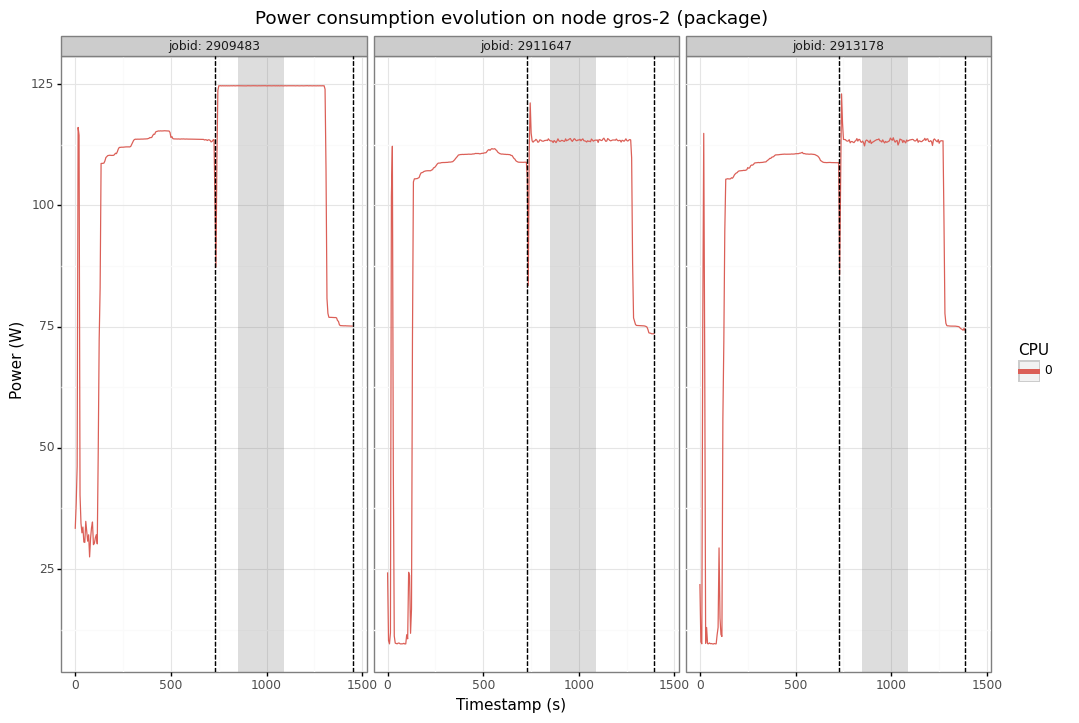

<ggplot: (8765866356800)>


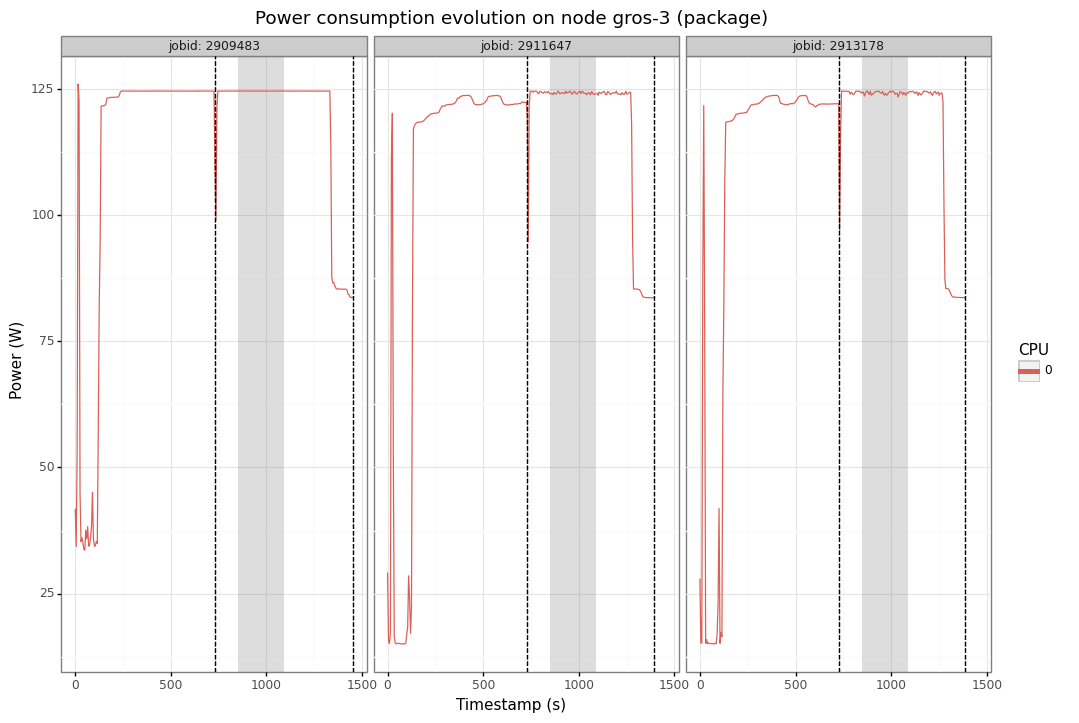

<ggplot: (8765866515618)>


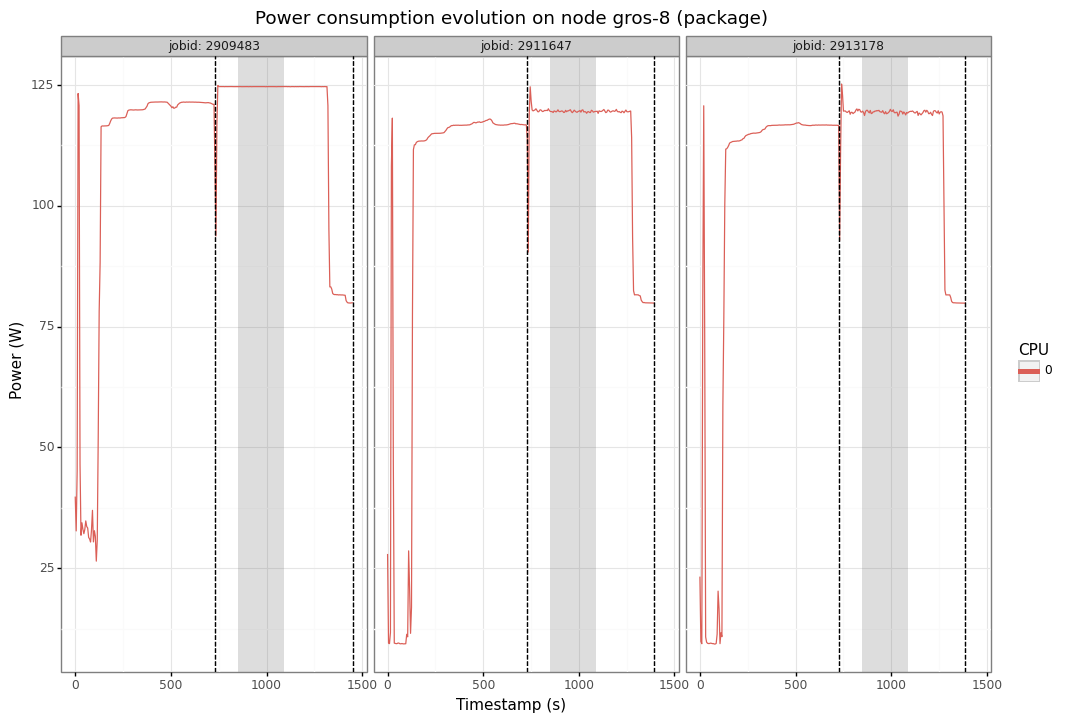

<ggplot: (-9223363271033431464)>


In [6]:
cluster = df['cluster'].unique()
assert len(cluster) == 1
cluster = cluster[0]

for node in [2, 3, 8]:
    tmp = filter_nodes(df[df['kind'] == 'power_cpu'], node)
    print(plot_evolution(tmp, 'value')
        + ggtitle(f'Power consumption evolution on node {cluster}-{node} (package)')
        + ylab('Power (W)')
        + expand_limits(y=(110, 125))
    )